# Inbalanced Classes
## In this lab, we are going to explore a case of imbalanced classes. 


Like we disussed in class, when we have noisy data, if we are not careful, we can end up fitting our model to the noise in the data and not the 'signal'-- the factors that actually determine the outcome. This is called overfitting, and results in good results in training, and in bad results when the model is applied to real data. Similarly, we could have a model that is too simplistic to accurately model the signal. This produces a model that doesnt work well (ever). 


In [8]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### First, download the data from: https://www.kaggle.com/ntnu-testimon/paysim1. Import the dataset and provide some discriptive statistics and plots. What do you think will be the important features in determining the outcome?

In [2]:
# Your code here

fraud = pd.read_csv('../data/PS_20174392719_1491204439457_log.csv')
fraud.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
# Check types
fraud.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [4]:
# Check numeric variables
fraud.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [5]:
# Check if there is null values
fraud.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

(8.5, -0.5)

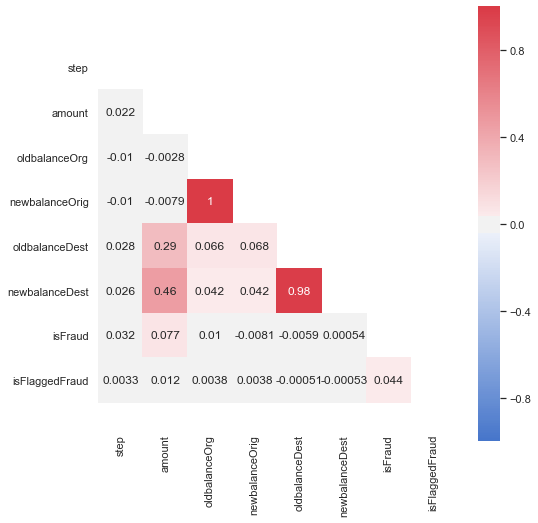

In [9]:
# Correlation Matrix Heatmap Visualization
sns.set(style="white")
# Generate a mask for the upper triangle
mask = np.zeros_like(fraud.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure to control size of heatmap
fig, ax = plt.subplots(figsize=(8,8))
# Create a custom color palette
cmap = sns.diverging_palette(255, 10, as_cmap=True)  # as_cmap returns a matplotlib colormap object rather than a list of colors
# Red=10, Green=128, Blue=255
# Plot the heatmap
sns.heatmap(fraud.corr(), mask=mask, annot=True, square=True, cmap=cmap , vmin=-1, vmax=1, ax=ax)  # annot display corr label
# Prevent Heatmap Cut-Off Issue
bottom, top = ax.get_ylim()
ax.set_ylim(bottom+0.5, top-0.5)

# There are not strong correlation between isFraud and the other variables

### What is the distribution of the outcome? 

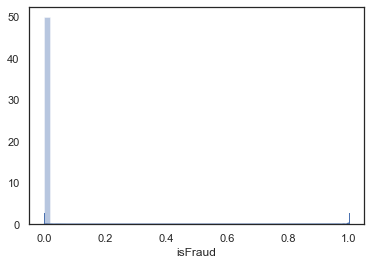

In [10]:
# The distribution of the outcome variable is very unbalanced
sns.distplot(fraud['isFraud'], rug=True, hist=True)

In [11]:
fraud['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

### Clean the dataset. How are you going to integrate the time variable? Do you think the step (integer) coding in which it is given is appropriate?

In [12]:
# The amount of time of each transaction in in a integer number which I think it is fine (not need of transformation). 
# It is bassically a difference between dates, so it is ok.

## Transform Type (categorical) to Numerical

fraud['type'].value_counts()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

In [14]:
payment_dummies = pd.get_dummies(fraud['type'])
fraud = pd.concat([fraud.drop('type', axis=1), payment_dummies], axis=1)
fraud.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,0,0,0,1,0
1,1,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,0,0,0,1,0
2,1,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,0,0,0,0,1
3,1,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,0,1,0,0,0
4,1,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,0,0,0,1,0


In [15]:
## Balance the classes before running a Model
from imblearn.under_sampling import RandomUnderSampler

numerical = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'oldbalanceDest', 'isFlaggedFraud', 
     'CASH_IN', 'CASH_OUT', 'DEBIT', 'PAYMENT', 'TRANSFER']

Ramdom_sample = RandomUnderSampler(random_state=42)
X, y = Ramdom_sample.fit_resample(fraud[numerical], fraud['isFraud'])

Using TensorFlow backend.


### Run a logisitc regression classifier and evaluate its accuracy.

In [28]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
def baseline_report(model, X_train, X_test, y_train, y_test, name):
    strat_k_fold = StratifiedKFold(n_splits=5, shuffle=True)
    model.fit(X_train, y_train)
    accuracy     = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='accuracy'))
    precision    = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='precision'))
    recall       = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='recall'))
    f1score      = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='f1'))
    rocauc       = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='roc_auc'))
    y_pred = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_pred, y_test).ravel()
    specificity = tn / (tn+fp)

    df_model = pd.DataFrame({'model'        : [name],
                             'accuracy'     : [accuracy],
                             'precision'    : [precision],
                             'recall'       : [recall],
                             'f1score'      : [f1score],
                             'rocauc'       : [rocauc],
                             'specificity': [specificity]})
    return df_model

In [30]:
# Your code here

models = {'Logistic Regression': LogisticRegression(),
          'randomforest': RandomForestClassifier(),
         }

models_df_offer = pd.concat([baseline_report(model, X_train, X_test, y_train, y_test, name) for (name, model) in models.items()])
models_df_offer

,model,accuracy,precision,recall,f1score,rocauc,specificity
0,Logistic Regression,0.914231,0.885162,0.960306,0.918755,0.978190,0.977654
0,randomforest,0.987291,0.983410,0.991941,0.986974,0.997026,0.995729


### Now pick a model of your choice and evaluate its accuracy.

In [ ]:
# Your code here

### Which model worked better and how do you know?

In [ ]:
# Your response here

# The model that worked better is the Random Forest Classifier, because the different 
#metrics (accuracy, precisiob, recall, F1score, ROC) performed better. Also, for this problem,
# we are interested in the minimization of the False Positive cases. Therefore a specificity metric was also 
# calculated. In any case, Random Forest performed better than Logistic Regression.